# Imports

In [1]:
# # File saved on google drive
# from google.colab import drive
# drive.mount('/content/drive')

In [11]:
import pandas as pd
import numpy as np
import os
import requests
import sys
import json
from datetime import datetime, timedelta
import holidays
import scipy
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, plot_roc_curve, confusion_matrix, accuracy_score

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from scipy.stats import reciprocal, uniform, randint

## Constants

In [12]:
random_state = 42
np.random.seed(random_state)

## Functions

In [77]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=4, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.legend(loc="lower right", fontsize=16)

def get_roc_scores(model, X, y):
    y_scores = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, y_scores)

    i = np.argmax(tpr - fpr)
    print(thresholds[i])
    return fpr, tpr, thresholds, i

def plot_roc_threshold_curves(model, X, y, modelName = "Default"):
    fpr, tpr, thresholds, i = get_roc_scores(model, X, y)
    fig = plt.figure(figsize=(16,8))
    fig.add_subplot(121)
    plot_roc_curve(fpr, tpr, modelName)
    plt.scatter(fpr[i], tpr[i], c='r', s=100)
    plt.title('ROC Curve');

    fig.add_subplot(122)
    plt.plot(thresholds)
    plt.scatter(i, thresholds[i], c='r')
    plt.title('Thresholds');

# Data Modelling

## Import Cleaned CSV

In [14]:
os.getcwd()

'd:\\repos\\BikeShareTO-ActiveAI\\notebooks'

In [15]:
# data_path = "/content/drive/MyDrive/Project/data/final_trip_feature_data.csv"
# df_full_non_zero_net_demand_trim = pd.read_csv(data_path)
data_path = "..\\data\\final_trip_feature_data.csv"
df_full_non_zero_net_demand_trim = pd.read_csv(data_path)

In [16]:
df_full_non_zero_net_demand_trim = df_full_non_zero_net_demand_trim.rename(columns={
    "Start Station Id" : "Station Id",
    "Binned_Start_Time" : "Time",
    "capacity" : "Station Capacity",
    "nearest_transit" : "Nearest Transit Station Name",
    "POI_distance" : "Distance to Nearest Transit Station",
    "Is_Weekend" : "Weekend",
    "Active_TO" : "Active TO",
    "Lockdown_Stay_at_Home" : "Lockdown"
})

In [17]:
df_full_non_zero_net_demand_trim[['Active TO','Lockdown','Holiday','Weekend']] = df_full_non_zero_net_demand_trim[['Active TO','Lockdown','Holiday','Weekend']].astype(pd.SparseDtype("int64",0))

In [18]:
df_full_non_zero_net_demand_trim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1912438 entries, 0 to 1912437
Data columns (total 18 columns):
 #   Column                               Dtype           
---  ------                               -----           
 0   Station Id                           int64           
 1   Time                                 object          
 2   Station Capacity                     int64           
 3   Nearest Transit Station Name         object          
 4   Distance to Nearest Transit Station  float64         
 5   Temp (°C)                            float64         
 6   Precip. Amount (mm)                  float64         
 7   Wind Spd (km/h)                      float64         
 8   Wind Dir (10s deg)                   float64         
 9   Visibility (km)                      float64         
 10  Holiday                              Sparse[int64, 0]
 11  Weekend                              Sparse[int64, 0]
 12  Year                                 int64           
 1

In [19]:
#df_full_non_zero_net_demand_trim = df_full_non_zero_net_demand_trim.sample(frac = 0.1, random_state = 42)

In [20]:
df_full_non_zero_net_demand_trim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1912438 entries, 0 to 1912437
Data columns (total 18 columns):
 #   Column                               Dtype           
---  ------                               -----           
 0   Station Id                           int64           
 1   Time                                 object          
 2   Station Capacity                     int64           
 3   Nearest Transit Station Name         object          
 4   Distance to Nearest Transit Station  float64         
 5   Temp (°C)                            float64         
 6   Precip. Amount (mm)                  float64         
 7   Wind Spd (km/h)                      float64         
 8   Wind Dir (10s deg)                   float64         
 9   Visibility (km)                      float64         
 10  Holiday                              Sparse[int64, 0]
 11  Weekend                              Sparse[int64, 0]
 12  Year                                 int64           
 1

### Train Test Split

In [21]:
X = df_full_non_zero_net_demand_trim.drop("Positive Net Demand", axis = 1)
Y = df_full_non_zero_net_demand_trim["Positive Net Demand"].copy()

In [22]:
X_train_pre_pipeline, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = random_state, stratify = Y)

## Pipeline Creation

In [23]:
# This class is defined in the textbook and simply restricts the dataframe to specific features
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [24]:
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(['Station Capacity','Distance to Nearest Transit Station', 'Temp (°C)', 'Precip. Amount (mm)', 'Wind Spd (km/h)',
           'Month','Holiday', 'Weekend', 'Active TO', 'Lockdown'])),
            ('std_scaler', RobustScaler())
    ])

In [25]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(['Time', 'Nearest Transit Station Name'])),
        ("cat_encoder", OneHotEncoder(categories='auto')),
    ])

In [26]:
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [27]:
X_train_prepared = preprocess_pipeline.fit_transform(X_train_pre_pipeline)

In [28]:
X_train_prepared.shape

(1338706, 76)

In [29]:
y_train_ravel = np.ravel(y_train)

# PCA

In [19]:
# pca = PCA(n_components = 0.95 )
# X_reduced = pca.fit_transform(X_train_prepared)

In [20]:
# X_reduced.shape

# Logistic Regression

In [71]:
log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=random_state)
score = cross_val_score(log_clf, X_train_prepared, y_train_ravel, cv=3, verbose=3, scoring = 'roc_auc', n_jobs=8)
score.mean()

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:   38.2s finished


0.5683012043057194

In [72]:
log_clf.fit(X_train_prepared, y_train_ravel)

LogisticRegression(max_iter=1000, random_state=42)

0.4853668369755925


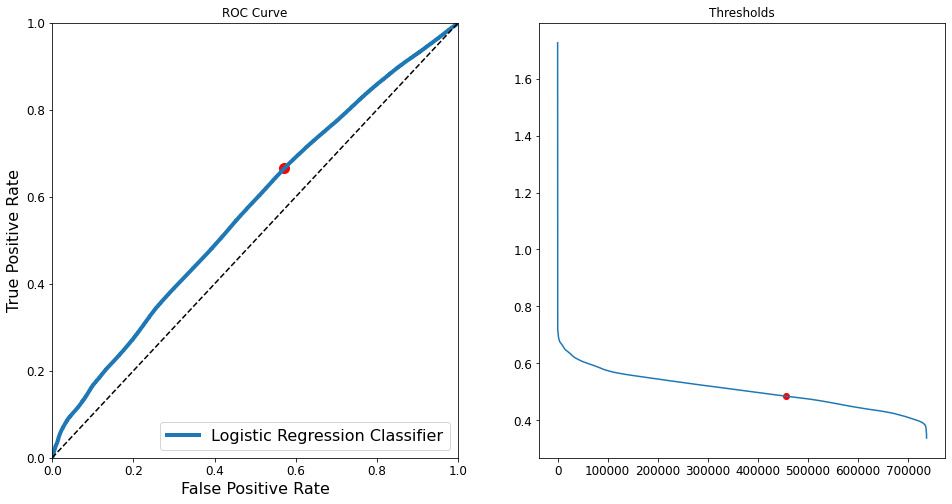

In [78]:
plot_roc_threshold_curves(log_clf, X_train_prepared, y_train_ravel, "Logistic Regression Classifier")

# Polynomial Logistic Regression Classifier

## Degree = 2

In [80]:
poly_features_2 = PolynomialFeatures(degree=2, include_bias=False)
X_train_prepared_poly_2 = poly_features_2.fit_transform(X_train_prepared)

In [81]:
log_clf = LogisticRegression(solver="lbfgs", random_state=random_state)
score_2 = cross_val_score(log_clf, X_train_prepared_poly_2, y_train_ravel, cv=3, verbose=3, scoring = 'roc_auc', n_jobs = 8)
score_2.mean()

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:   38.3s finished


0.620925240269342

In [82]:
log_clf.fit(X_train_prepared_poly_2, y_train_ravel)

C:\Users\215795\.conda\envs\machinelearning\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(random_state=42)

0.5091124003237063


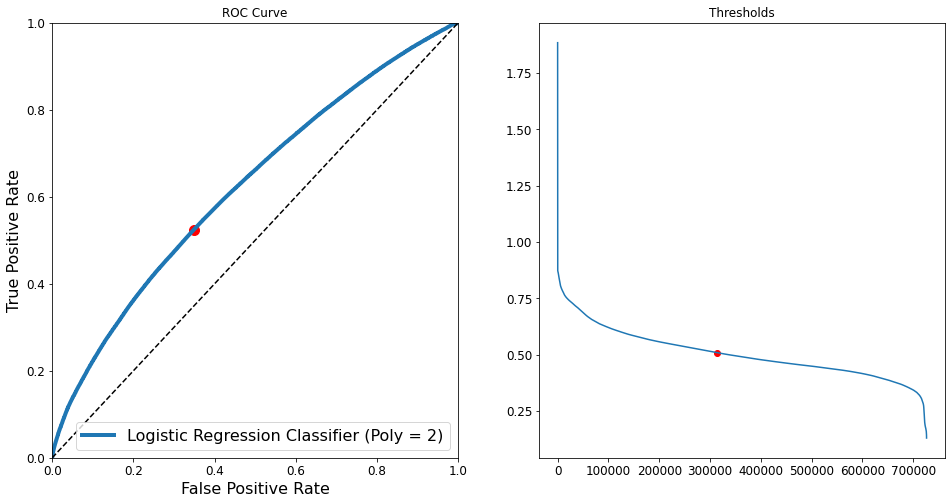

In [83]:
plot_roc_threshold_curves(log_clf, X_train_prepared_poly_2, y_train_ravel, "Logistic Regression Classifier (Poly = 2)")

## Degree = 3

In [84]:
poly_features_3 = PolynomialFeatures(degree=3, include_bias=False)
X_train_prepared_poly_3 = poly_features_3.fit_transform(X_train_prepared)

In [85]:
log_clf = LogisticRegression(solver="lbfgs", random_state=random_state)
score_3 = cross_val_score(log_clf, X_train_prepared_poly_3, y_train_ravel, cv=3, verbose=3, scoring = 'roc_auc', n_jobs=8)
score_3.mean()

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:  1.5min finished


0.6397139794995109

In [86]:
log_clf.fit(X_train_prepared_poly_3, y_train_ravel)

C:\Users\215795\.conda\envs\machinelearning\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(random_state=42)

0.5101503919717302


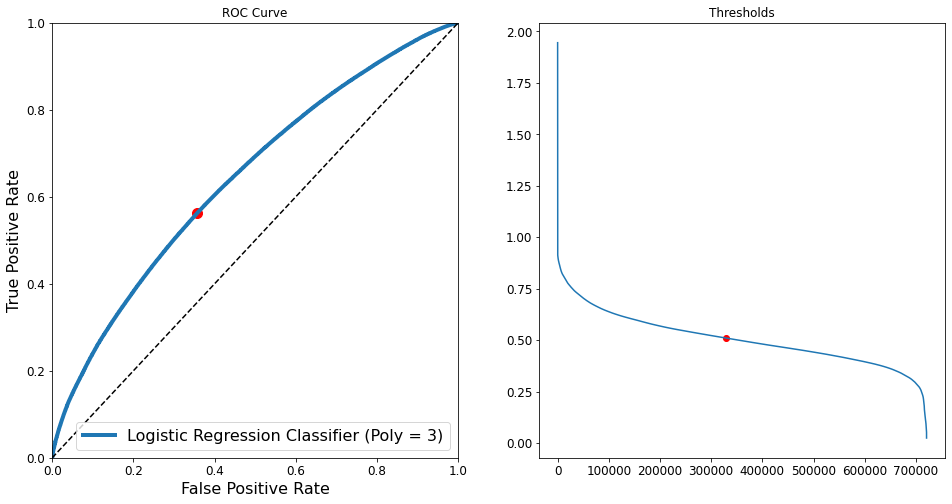

In [88]:
plot_roc_threshold_curves(log_clf, X_train_prepared_poly_3, y_train_ravel, "Logistic Regression Classifier (Poly = 3)")

In [90]:
X_test_prepared_poly_3 = poly_features_3.fit_transform(X_test_prepared)

0.5090756207856317


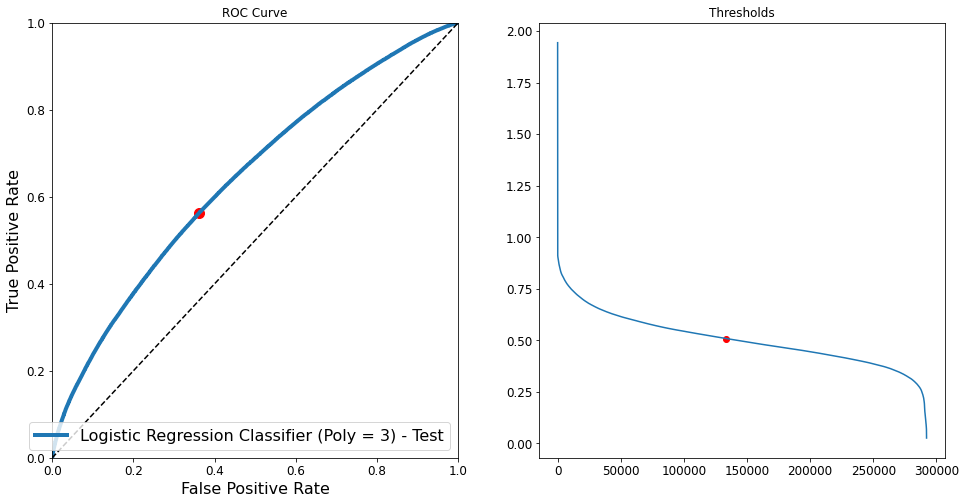

In [91]:
plot_roc_threshold_curves(log_clf, X_test_prepared_poly_3, np.ravel(y_test), "Logistic Regression Classifier (Poly = 3) - Test")

## Degree = 4

In [95]:
poly_features_4 = PolynomialFeatures(degree=4, include_bias=False)
X_train_prepared_poly_4 = poly_features_4.fit_transform(X_train_prepared)

KeyboardInterrupt: 

In [ ]:
log_clf = LogisticRegression(solver="lbfgs", random_state=random_state)
score_4 = cross_val_score(log_clf, X_train_prepared_poly_4, y_train_ravel, cv=3, verbose=3, scoring = 'roc_auc')
score_4.mean()

In [ ]:
log_clf.fit(X_train_prepared_poly_4, y_train_ravel)

In [ ]:
y_scores_log_clf_4 = log_clf.predict_proba(X_train_prepared_poly_4)[:, 1]
fpr_log_clf_4, tpr_log_clf_4, thresholds_log_clf_4 = roc_curve(y_train, y_scores_log_clf_4)

i = np.argmax(tpr_log_clf_4 - fpr_log_clf_4)
thresholds_log_clf_4[i]

In [ ]:
fig = plt.figure(figsize=(16,8))
fig.add_subplot(121)
plot_roc_curve(fpr_log_clf_4, tpr_log_clf_4, "Logistic Regression Classifier")
plt.scatter(fpr_log_clf_4[i], tpr_log_clf_4[i], c='r', s=100)
plt.title('Training ROC Curve');

fig.add_subplot(122)
plt.plot(thresholds_log_clf_4)
plt.scatter(i, thresholds_log_clf_4[i], c='r')
plt.title('Thresholds');

# K Nearest Neighbours

In [21]:
KN_clf = KNeighborsClassifier()

KN_param_grid= [{'n_neighbors':[20,50,100,200]}]

In [22]:
KN_grid_search = GridSearchCV(KN_clf, KN_param_grid, cv = 3, scoring = 'roc_auc')
KN_grid_search.fit(X_train_prepared, y_train_ravel)

KeyboardInterrupt: 

In [ ]:
bmodel = KN_grid_search.best_estimator_

In [ ]:
KN_grid_search.best_score_

In [ ]:
KN_grid_search.best_estimator_

In [ ]:
roc_auc_score(X_train, Y_train)

In [ ]:
X_test_tx = preprocess_pipeline.transform(X_test)

In [ ]:
y_test_pred = bmodel.predict(X_test_tx)

In [ ]:
accuracy_score(Y_test, y_test_pred)

In [ ]:
roc_auc_score(Y_test, y_test_pred)

In [ ]:
from sklearn.metrics import roc_curve

y_test_score = bmodel.predict_proba(X_test_tx)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(Y_test, y_test_score[:,1])

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0, 1, -0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
#Plot the Roc Curve
plot_roc_curve(fpr_forest, tpr_forest, "KN")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
# #%%time
# forest_PCA = RandomForestClassifier(n_estimators=100, random_state=0)
# accuracy = forest_PCA.fit(X_reduced,Y_train)

# AdaBoost

## AdaBoost with default base classifier

In [43]:
tree_clf = AdaBoostClassifier(random_state=random_state)

In [47]:
scores = cross_val_score(tree_clf, X_train_prepared, y_train, n_jobs=8, verbose =3, cv=3, scoring = 'roc_auc')
scores.mean()

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:  1.6min finished


0.5681121813031594

### Decision Tree 

Using best parameters provided by Siqi

In [55]:
base_tree_clf = DecisionTreeClassifier(criterion = 'gini',max_depth = 46, max_leaf_nodes = 432, min_samples_leaf = 372, min_samples_split = 198)

In [56]:
scores = cross_val_score(base_tree_clf, X_train_prepared, y_train, n_jobs=8, verbose =3, cv=3, scoring = 'roc_auc')
scores.mean()

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:   41.9s finished


0.659348884108447

In [57]:
base_tree_clf.fit(X_train_prepared, y_train)

DecisionTreeClassifier(max_depth=46, max_leaf_nodes=432, min_samples_leaf=372,
                       min_samples_split=198)

In [58]:
X_test_prepared=preprocess_pipeline.fit_transform(X_test)
y_test_pred = base_tree_clf.predict_proba(X_test_prepared)
roc_auc_score(y_test, y_test_pred[:,1])

0.6609486801393072

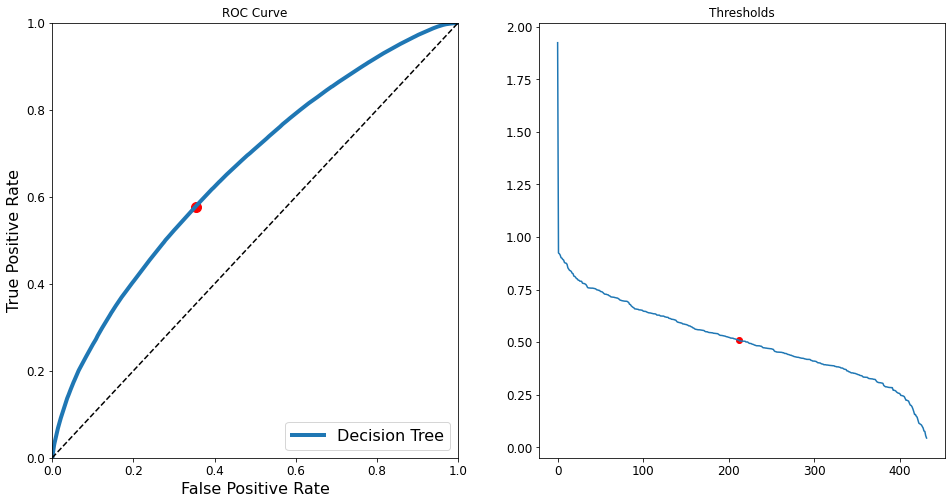

In [76]:
plot_roc_threshold_curves(base_tree_clf, X_test_prepared, y_test, "Decision Tree")

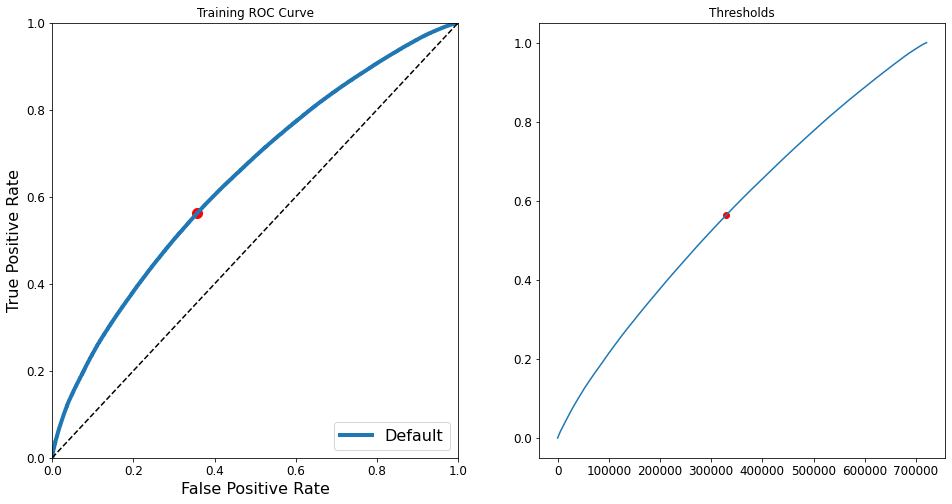

In [64]:
plot_roc_threshold_curves(log_clf, X_train_prepared_poly_3, y_train)

In [48]:
ada_tree_clf = AdaBoostClassifier(base_estimator = base_tree_clf, random_state=random_state, algorithm='SAMME.R')

In [49]:
param_1 = {'n_estimators': [500, 1000]}


In [ ]:
ada_tree_clf_1 = GridSearchCV(ada_tree_clf, param_1, cv=3, scoring='roc_auc', n_jobs=-1, verbose = 3)
ada_tree_clf_1.fit(X_train_prepared, np.ravel(y_train))
score_1 = ada_tree_clf_1.cv_results_['mean_test_score']

Fitting 3 folds for each of 2 candidates, totalling 6 fits


In [ ]:
print(param_1)
print(score_1)

In [ ]:
from datetime import datetime

now = datetime.now()